# 211207 ???

In [1]:
from pathlib import Path
import json

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import h5py as h5

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

## Setup

In [5]:
infiles = dict(
    # genomes=Path('data-processed/211111-inspect-genomes/genomes.csv'),
    genomes=Path('data-intermediate/211207-get-taxonomy/genome-taxonomy.csv'),
    pw_dists=Path('data-intermediate/211206-pw-dists/pw-dists.h5'),
    taxa=Path('data-intermediate/211207-get-taxonomy/taxa.csv'),
)

## Load data

### Genomes

In [6]:
genomes_df = pd.read_csv(infiles['genomes'], index_col=0)
ngenomes = genomes_df.shape[0]
ngenomes

14388

### Taxonomy

In [7]:
taxa_df = pd.read_csv(infiles['taxa'], index_col=0)
ntaxa = taxa_df.shape[0]
ntaxa

15303

In [8]:
RANKS = ['phylum', 'class', 'order', 'family', 'genus', 'species']

### Distance matrix

In [9]:
with h5.File(infiles['pw_dists']) as f:
    dmat_uids = f['uid'][:]
    dmat = f['pw_dists'][:]

## Build tree

In [10]:
from ete3 import Tree

/home/jared/opt/anaconda3/envs/gambit/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/jared/opt/anaconda3/envs/gambit/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [11]:
nodes = dict()

for taxid, row in taxa_df.iterrows():
    if row.parent_taxid == 0:
        node = Tree(name=taxid)
    else:
        node = nodes[row.parent_taxid].add_child(name=taxid)
        
    node.add_features(
        taxid=taxid,
        tname=row['name'],
        rank=row['rank'],
        genome_idxs=[],
    )
    
    nodes[taxid] = node

root = nodes[2]

In [12]:
root.describe()

Number of leaf nodes:	11836
Total number of nodes:	15303
Rooted:	No
Most distant node:	245
Max. distance:	6.000000


In [13]:
for idx, uid in enumerate(dmat_uids):
    if not genomes_df.loc[uid, 'use']:
        continue
        
    taxid = genomes_df.loc[uid, 'species_taxid']
    nodes[taxid].genome_idxs.append(idx)

In [14]:
for node in root.traverse('postorder'):
    for child in node.children:
        node.genome_idxs.extend(child.genome_idxs)
        
    node.genome_idxs = np.asarray(sorted(node.genome_idxs))
    assert len(node.genome_idxs) == taxa_df.loc[node.taxid, 'ngenomes']

## ?

### Diameters

In [15]:
for node in tqdm(nodes.values()):
    diam = dmat[np.ix_(node.genome_idxs, node.genome_idxs)].max()
    node.add_feature('diameter', diam)

100%|██████████| 15303/15303 [00:00<00:00, 18899.81it/s]


In [16]:
taxa_df['diameter'] = [nodes[taxid].diameter for taxid in taxa_df.index]

In [21]:
taxa_df['diam2'] = 1 - taxa_df['diameter'] + 1e-8

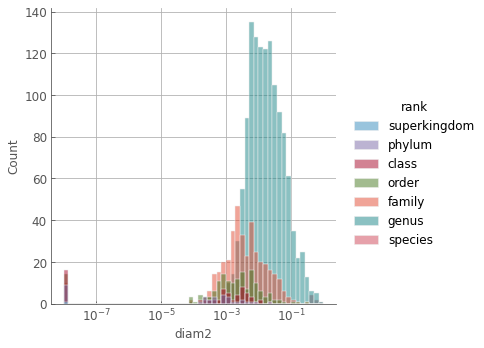

In [24]:
sns.displot(
    taxa_df[taxa_df['ngenomes'] > 1],
    x='diam2',
    log_scale=True,
    # col='rank',
    hue='rank',
    # facet_kws=dict(sharey=False),
    # col_wrap=4,
)

In [ ]:
taxa_df.loc[(taxa_df['rank'] == 'genus') & (taxa_df['ngenomes'] > 1), 'diameter']

In [ ]:
plt.hist(_)
plt.gca().set_yscale('log')

In [ ]:
sns.displot(
    data=taxa_df[taxa_df['ngenomes'] > 1],
    x='ngenomes',
    col='rank',
    facet_kws=dict(sharey=False, sharex=False),
    col_wrap=4,
)

In [ ]:
sns.relplot(
    data=taxa_df[taxa_df['ngenomes'] > 1],
    x='ngenomes',
    y='diameter',
    col='rank',
    facet_kws=dict(sharey=False, sharex=False),
    col_wrap=4,
)

## ?

In [ ]:
from gambit.db import file_sessionmaker, Taxon, AnnotatedGenome

Session = file_sessionmaker('/home/jared/projects/gambit/data/databases/refseq-curated/1.0-beta2/gambit-genomes-1.0b2-211111.db')
session = Session()

In [ ]:
db_genomes = {g.ncbi_id: g for g in session.query(AnnotatedGenome).all()}

In [ ]:
intersect_genomes = db_genomes.keys() & set(genomes_df.index[genomes_df['use']])
len(intersect_genomes)

In [ ]:
db_genera = {taxon.ncbi_id: taxon for taxon in session.query(Taxon).filter_by(rank='genus')}

In [ ]:
intersect_genera = db_genera.keys() & set(taxa_df.index)
len(intersect_genera)

In [ ]:
gid in db_genomes

In [ ]:
intersect_map = dict()
taxid_mismatch = []

for gid in intersect_genomes:
    sp_node = nodes[genomes_df.loc[gid, 'species_taxid']]
    genus_node = sp_node.up
    assert genus_node.rank == 'genus'

    genome = db_genomes[gid]
    taxon = genome.taxon
    while taxon.rank != 'genus':
        taxon = taxon.parent
        
    if taxon.ncbi_id == genus_node.taxid:
        intersect_map.setdefault(genus_node.taxid, []).append(gid)
    else:
        taxid_mismatch.append((gid, genus_node.taxid, taxon.ncbi_id))

In [ ]:
len(taxid_mismatch), len(intersect_map), sum(map(len, intersect_map.values()))

In [ ]:
from collections import Counter
Counter(map(len, intersect_map.values()))

In [ ]:
taxid, gids = max(intersect_map.items(), key=lambda item: (len(item[1]) > 1, -nodes[item[0]].diameter))

In [ ]:
df = pd.DataFrame.from_records([
    dict(
        taxid=taxid,
        db_thresh=db_genera[taxid].distance_threshold,
        diameter=nodes[taxid].diameter,
        ngenomes=len(gids)
    )
    for taxid, gids in intersect_map.items()
])
df.sort_values('diameter', ascending=True, inplace=True)

In [ ]:
df[df['ngenomes'] > 1]

In [ ]:
db_genera[taxid].distance_threshold

In [ ]:
nodes[taxid].diameter

In [ ]:
genomes_df.loc[gids]

In [ ]:
taxon.ncbi_id

In [ ]:
genus_node.taxid

In [ ]:
genus_node.tname

In [ ]:
genome.taxon.rank

### ?

In [ ]:
taxids_by_rank = dict(iter(taxa_df.reset_index().groupby('rank')['taxid']))

In [ ]:
taxa_df[taxa_df['rank'] == 'phylum']